In [48]:
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LeakyReLU
import numpy as np
import time
import json

from IPython import display

In [49]:
BATCH_SIZE = 32
MAP_SIZE = 32
LR_D = LR_G = 0.00005

In [50]:
N = 32

def generate_rect(x, y, w, h):
  data = np.zeros((N,N))
  data[x:x+w+1, y:y+h+1] = 1
  data[x+1:x+w, y+1:y+h] = 0
  #data = np.reshape(data, (N*N))
  return data

train_images = []

for x in range(0, N-2):
  for y in range(0, N-2):
    for w in range(2,N):
      for h in range(2,N):
        if x+w<N and y+h<N:
          train_images.append(generate_rect(x,y,w,h))
train_images = np.array(train_images).astype('int32')
train_images = train_images[np.random.choice(np.shape(train_images)[0], 1000, replace=False)]

print(np.shape(train_images))

(1000, 32, 32)


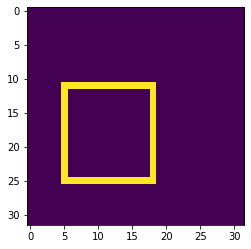

In [58]:
plt.imshow(train_images[2])


In [5]:
train_size, x_dims, y_dims = train_images.shape
z_dims = np.amax(train_images) + 1 # Number of different title types
print(z_dims)
train_images_onehot = np.eye(z_dims, dtype='uint8')[train_images]
print(train_images_onehot.shape) # (train_size, x_dims, y_dims, z_dims)

train_images = np.zeros((train_size, MAP_SIZE, MAP_SIZE, z_dims))
print(train_images.shape)

# TODO: Change empty space encoding here if different
train_images[:, :, :, 1] = 0.0  # Fill with empty space 

train_images[:train_size, :x_dims, :y_dims, :] = train_images_onehot
print(train_images.shape)

2
(1000, 32, 32, 2)
(1000, 32, 32, 2)
(1000, 32, 32, 2)


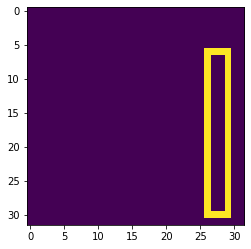

In [6]:
plt.imshow(np.argmax(train_images[2], axis=2))

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(train_images.shape[0]).batch(BATCH_SIZE)

In [8]:
optimizer = tf.optimizers.Adam(0.0002, 0.5)

In [9]:
def make_discriminator_model(n_extra_layers=0):
  assert MAP_SIZE % 16 == 0
  
  model = Sequential()
  model.add(Dense(1024, input_dim=(32*32*2)))
  model.add(LeakyReLU(0.2))
  model.add(Dense(512))
  model.add(LeakyReLU(0.2))
  model.add(Dense(256))
  model.add(LeakyReLU(0.2))

  
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer=optimizer)

  return model

In [10]:
def make_generator_model(n_extra_layers=0):
  assert MAP_SIZE % 16 == 0

  noise_size = 128
  # 32 here is the 1/2 * n_channels before last Conv2DTranspose
  n_filters = 32 * MAP_SIZE / 4

  model = tf.keras.Sequential()
  model.add(Dense(256, input_dim=noise_size))
  model.add(LeakyReLU(0.2))

  model.add(Dense(512))
  model.add(LeakyReLU(0.2))

  model.add(Dense(1024))
  model.add(LeakyReLU(0.2))

  model.add(Dense((32*32*2), activation='tanh'))
  model.compile(loss='binary_crossentropy', optimizer=optimizer)

  return model

In [11]:
steps_per_epoch = 3750
epochs = 10
noise_dim = 128

from keras.layers import Input
from keras.models import Model

gan_input = Input(shape=(noise_dim,))

In [12]:
"""import os
TPU_WORKER = "grpc://" + os.environ["COLAB_TPU_ADDR"]
tf.config.experimental_connect_to_host(TPU_WORKER)

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(TPU_WORKER)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)"""

'import os\nTPU_WORKER = "grpc://" + os.environ["COLAB_TPU_ADDR"]\ntf.config.experimental_connect_to_host(TPU_WORKER)\n\nresolver = tf.distribute.cluster_resolver.TPUClusterResolver(TPU_WORKER)\ntf.tpu.experimental.initialize_tpu_system(resolver)\nstrategy = tf.distribute.TPUStrategy(resolver)'

In [13]:
"""with strategy.scope():
    discriminator = make_discriminator_model()
    generator = make_generator_model()

    fake_image = generator(gan_input)
    gan_output = discriminator(fake_image)

    gan = Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer) """
    
    

"with strategy.scope():\n    discriminator = make_discriminator_model()\n    generator = make_generator_model()\n\n    fake_image = generator(gan_input)\n    gan_output = discriminator(fake_image)\n\n    gan = Model(gan_input, gan_output)\n    gan.compile(loss='binary_crossentropy', optimizer=optimizer) "

In [14]:
discriminator = make_discriminator_model()
generator = make_generator_model()

fake_image = generator(gan_input)
gan_output = discriminator(fake_image)

gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=optimizer) 

In [15]:
for epoch in range(epochs):
    for batch in range(steps_per_epoch):
        noise = np.random.normal(0, 1, size=(BATCH_SIZE, noise_dim))
        fake_x = generator.predict(noise, verbose = 0)
        #fake_x = np.reshape(fake_x, (fake_x.shape[0],32,32,2))
        real_x = train_images[np.random.randint(0, train_images.shape[0], size=BATCH_SIZE)]
        real_x = np.reshape(real_x, (fake_x.shape[0], fake_x.shape[1]))
        #x = np.concatenate((real_x, fake_x))

        #disc_y = np.zeros(2*BATCH_SIZE)
        #disc_y[:BATCH_SIZE] = 0.9

        disc_y = np.ones(BATCH_SIZE)

        d_loss = discriminator.train_on_batch(real_x, disc_y)

        y_gen = np.ones(BATCH_SIZE)
        g_loss = gan.train_on_batch(noise, y_gen)

    print(f'Epoch: {epoch} \t Discriminator Loss: {d_loss} \t\t Generator Loss: {g_loss}')

Epoch: 0 	 Discriminator Loss: 0.7905850410461426 		 Generator Loss: 0.45158135890960693
Epoch: 1 	 Discriminator Loss: 0.8023945093154907 		 Generator Loss: 0.4632791578769684
Epoch: 2 	 Discriminator Loss: 0.7092207074165344 		 Generator Loss: 0.41824644804000854
Epoch: 3 	 Discriminator Loss: 0.7118672132492065 		 Generator Loss: 0.4130626320838928
Epoch: 4 	 Discriminator Loss: 0.7156278491020203 		 Generator Loss: 0.41293370723724365
Epoch: 5 	 Discriminator Loss: 0.7093044519424438 		 Generator Loss: 0.4129125475883484
Epoch: 6 	 Discriminator Loss: 0.7093356847763062 		 Generator Loss: 0.4122404158115387
Epoch: 7 	 Discriminator Loss: 0.7095686197280884 		 Generator Loss: 0.4114077687263489
Epoch: 8 	 Discriminator Loss: 0.7098680734634399 		 Generator Loss: 0.4101942181587219
Epoch: 9 	 Discriminator Loss: 0.7092887759208679 		 Generator Loss: 0.4108816385269165


In [59]:
def show_images(noise):
    generated_images = generator.predict(noise)
    plt.figure(figsize=(10, 10))
    for i, image in enumerate(generated_images):
        plt.subplot(10, 10, i+1)
        if 2 == 1:
            plt.imshow(image.reshape((32, 32)), cmap='gray')
        else:
            plt.imshow(np.argmax(image.reshape(32, 32, 2), axis=2))
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

4/4 [==============================] - 0s 3ms/step


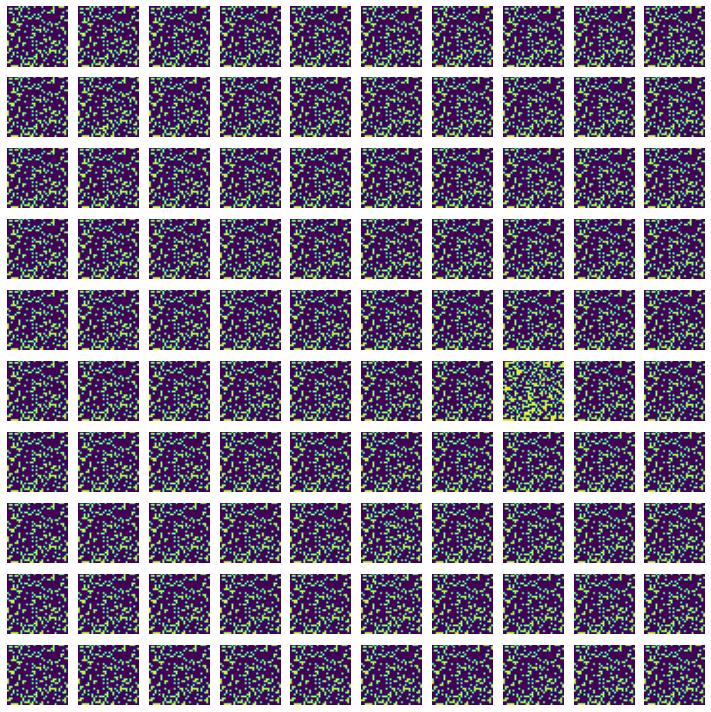

In [60]:
noise = np.random.normal(0, 1, size=(100, noise_dim))
show_images(noise)